# YOLO object detection with OpenCV
https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/

In [1]:
import numpy as np
import argparse
import time
import cv2
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

## Settings

In [2]:
image_path = 'images/soccer.jpg'
yolo_path = 'yolo-coco/'
min_confidence = 0.5  # Minimum probability to filter weak detections
threshold = 0.3  # Threshold when applying non-maxima suppression

## Preprocessing

In [3]:
# Load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([yolo_path, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# Initialize a list of colours to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# Derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([yolo_path, "yolov3.weights"])
configPath = os.path.sep.join([yolo_path, "yolov3.cfg"])

# Load our YOLO object detector trained on COCO dataset (80 classes)
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Load our input image and grab its spatial dimensions
image = cv2.imread(image_path)
(H, W) = image.shape[:2]

# Determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

## Classify image

In [4]:
# Construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# Show timing information on YOLO
print("YOLO has taken {:.6f} seconds".format(end - start))

YOLO has taken 0.589894 seconds


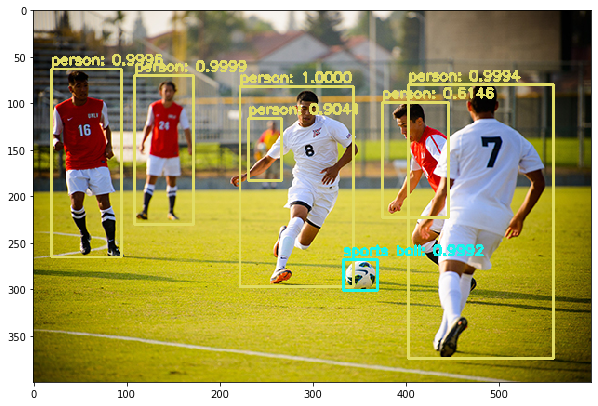

In [5]:
# Initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

# Loop over each of the layer outputs
for output in layerOutputs:
    # Loop over each of the detections
    for detection in output:
        # Extract the class ID and confidence (i.e., probability) of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        # Filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > min_confidence:
            # Scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            
            # Use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            
            # Update our list of bounding box coordinates, confidences and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
            
# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, threshold)

# Ensure at least one detection exists
if len(idxs) > 0:
    # Loop over the indices we are keeping
    for i in idxs.flatten():
        # Extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        # Draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Show the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))